In [12]:
#%matplotlib widget
#see https://stackoverflow.com/questions/50149562/jupyterlab-interactive-plot for how to zoom on plots!

<h1>Voyager 1 detection from recorded data</h1>
<h3>Nick Foster, 2019</h3>

This notebook details how to use time integration to locate and detect Voyager 1's signal from a recording. The example recording used here was recorded at the Allen Telescope Array in Hat Creek, CA on July 14, 2010. This recording (in SigMF format) can be found <a href="http://setiquest.info/sigmf/">here</a>. The notebook is general enough to be used with most any recording as long as you provide a valid SigMF header.

The Voyager 1 signal at 13,663,774,381 miles from Earth is far too weak to be plainly detectable in a spectrogram, even when using a radiotelescope array like the ATA, although world-class dishes such as the Goldstone observatory will be able to detect it strongly enough to see without further processing. Instead, to bring the signal out of the noise, we integrate over time. If we integrate for long enough, the power in the frequency bin corresponding to Voyager 1's carrier will increase enough to be detectable.

One problem with this approach is that we don't immediately know exactly where (in frequency) to look for the signal, due to <a href=https://en.wikipedia.org/wiki/Doppler_shift>Doppler shift</a>. There are three major sources of Doppler shift in this instance:

* Voyager 1's velocity relative to the Solar System (currently 38,026.77 mph)
* Voyager 1's velocity relative to Earth's orbit around the sun
* Voyager 1's velocity relative to the observatory as it rises and sets due to Earth's rotation

The first case, Voyager's velocity relative to the sun, is pretty static at this point -- no more thrust is being added to Voyager's trajectory, so it's not changing much (although interestingly there are some very small discrepancies from the expected velocity profile)

As Earth rotates around the sun once per year, its velocity relative to Voyager will change. Half the year it will be moving somewhat towards Voyager, and half the year away. Voyager's trajectory isn't collinear with Earth's orbital plane, so the magnitude of this effect is not exactly Earth's speed around the sun.

Viewed from an Earth observer's perspective, the Sun (or any other object in the sky) is moving toward you as it rises in the sky, and away from you as it sets. This effect causes a diurnal (once per day) change in Doppler shift, and also causes a further complication: the Doppler shift is likely to change over the course of your recording! If not compensated for, this will result in the energy coming from Voyager, which we want to be a nice spike in a single bin (from the carrier tone Voyager continually broadcasts), being smeared across multiple bins and thus much harder to detect.

We need to be able to calculate the magnitudes of the three velocities given above. Luckily, NASA JPL maintains a public-access tool called <a href="https://ssd.jpl.nasa.gov/?horizons">HORIZONS</a> to do exactly this. HORIZONS has accurate ephemerides (a set of numbers giving the position and velocity of an astronomical object) for a whole slew of man-made and astronomical objects. It also calculates relative velocities for any two objects, given the time of interest. It does a whole heck of a lot more than that, actually, but that's all we care about here. Even more luckily, there's a Python component for retrieving and parsing HORIZONS data.

So, we go out to HORIZONS, see where Earth and Voyager were relative to each other on July 14, 2010, and then we calculate an expected Doppler shift as well as the *drift* in that shift over the course of the recording. For the purposes of this notebook, we rely on a linear approximation of Doppler shift over the course of the recording. This is fine for recordings of an hour or so, but if you're really doing all-night observations of an astronomical target you probably want to account for this effect more precisely.

Once we have a Doppler shift profile, we go back to the original data and de-Doppler it so that hopefully the energy lies in a single bin. But, especially for long recordings and weak signals, this isn't quite accurate enough for good results! To maximize the height of the spike in our plot, which is always the goal of any communications engineer, we use the expected Doppler drift rate as the center point in a search pattern: we just try a bunch of candidate drift rates centered around the expected rate, and hope that one of them will be close enough to integrate cleanly without smearing the energy too much. If we've done things correctly, we should see the spike highest at or near the expected drift rate.

The following Python packages are necessary to run this notebook:

* Scipy
* Matplotlib/pyplot
* AstroPy (used for Julian date math)
* AstroQuery (used for downloading and processing ephemerides)

In [32]:
import scipy.signal
import scipy.fftpack
import numpy as np
import struct
import matplotlib.pyplot as plt
import math
import multiprocessing
import json
from astropy.time import Time,TimeDelta
from astroquery.jplhorizons import Horizons

<h2>Parameters</h2>
The processing parameters for the notebook are below. The values given are a good place to start, but do play with them!

In [23]:
metaname = 'vger1-2010-07-14-xpol.sigmf-meta'
filename = 'vger1-2010-07-14-xpol.sigmf-data'
sig_ctr = 8420.432097e6 #Voyager 1 center freq
observatory_code = -72 #set to -72 for HCRO, -9 for GBT
start_time = 0
end_time = 55
fftlen = 32768 #fftlen is FFT length on decimated data
bin_target = 1.0 #frequency bin size (data will be decimated to this bin width)

<h2>Loading metadata</h2>
This is a very very simple <a href="https://github.com/gnuradio/SigMF">SigMF</a> parser, to get the necessary fields from the accompanying metadata file.

In [24]:
metadata = {}
with open(metaname, 'r') as mf:
    metajson = json.load(mf)
    metadata["samp_rate"] = float(metajson["global"]["core:sample_rate"])
    if metadata["samp_rate"] < 0:
        invert_spectrum=True
        metadata["samp_rate"] = abs(metadata["samp_rate"])
    else:
        invert_spectrum=False
    metadata["frequency"] = float(metajson["captures"][0]["core:frequency"])
    metadata["date"] = metajson["captures"][0]["core:datetime"]
    metadata["format"] = {"ci16": np.int16, "ci8_be": np.int8}[metajson["global"]["core:datatype"]]

<h2>Going out to Horizons and calculating shifts and drifts</h2>

We use the SigMF recording data and the desired length of integration to calculate start and end times of interest. Then we go out to HORIZONS to get a good guess as to what the total Doppler shift will be, as well as how it will change over the course of the recording.

We're looking at 21 (odd number so that the center guess is present) candidate drift rates here.

In [25]:
rec_ctr   = metadata["frequency"] #center frequency of the recording
c = 2.99792458e8
nsecs = end_time-start_time #total amount of time to read from the file -- integration time

starttime = Time(metadata["date"], format="isot")+TimeDelta(start_time, format="sec")
doppler_deltat = 600 #time duration to use in Doppler drift estimate
jdtimes = [starttime, starttime+TimeDelta(doppler_deltat,format="sec")]
query = Horizons(id="Voyager 1",
                 location="%s" % observatory_code,
                 epochs=[jdtime.jd for jdtime in jdtimes],
                 id_type="majorbody")
eph = query.ephemerides()
dopplers = [sig_ctr*(c/(c+1000*i['delta_rate'])) for i in eph]
sig_start = dopplers[0]
drift_est = (dopplers[1]-dopplers[0])/doppler_deltat
offset = sig_start-rec_ctr #offset frequency at the start of the recording
candidate_drifts = np.linspace(drift_est-0.1, drift_est+0.1, 21)
print("Estimated center frequency: %.2f" % sig_start)
print("Estimated Doppler drift rate: %.3f/s" % drift_est)
print("Looking at %i drift rates between %.4fHz/s and %.4fHz/s" % (len(candidate_drifts), candidate_drifts[0], candidate_drifts[-1]))

Estimated center frequency: 8419545157.97
Estimated Doppler drift rate: -0.480/s
Looking at 21 drift rates between -0.5802Hz/s and -0.3802Hz/s


<h2>Calculate integration length and number of integrations</h2>
Based on the sample rate, number of FFT bins, desired bin width, and length of the recording, we calculate a decimation factor necessary to achieve that bin width. Play with the bin width and number of bins parameters above to see the effects of changing these parameters.

In [26]:
samplesize=np.dtype(metadata["format"]).itemsize
samp_rate = metadata["samp_rate"]
decim_rate = int(samp_rate/(bin_target*fftlen))
num_integrations = int(samp_rate*nsecs/decim_rate/fftlen)
print("Number of integrations: %i" % num_integrations)
input_veclen = int(fftlen * decim_rate)
print("Time per integration: %.2fs" % (fftlen*decim_rate/samp_rate))
print("FFT length: %i" % fftlen)
print("Decimation factor: %i" % decim_rate)
bin_size = samp_rate/fftlen/decim_rate
print("Bin size: %.2f" % bin_size)

Number of integrations: 57
Time per integration: 0.96s
FFT length: 32768
Decimation factor: 16
Bin size: 1.04


<h2>Doppler-correct and integrate!</h2>
This is the core of the notebook. It's presented as a routine so that we can parallelize the integrations, one for each candidate drift rate. There's a lot here, so let's take it slow.

First, we open the data file, and we move to the offset corresponding to the desired start time. Then we perform a number of integrations, each of which will be "stacked" on top of each other to produce a result. This is akin to stacking photographs in astrophotography; by doing so, weak signals will become more pronounced.

Some files are "IQ swapped", or spectrally inverted (i.e., -100Hz is actually 100Hz), so we account for that by performing a complex conjugation on the data if necessary.

Take a look at "freqvec" below. It's creating a map of Doppler shifts, over the length of time corresponding to the integration. We use the map to construct a signal, effectively a carrier whose frequency changes over the recording. We then mix this signal with the recording to de-Doppler the recording -- multiplication is a frequency mixing operation -- hopefully desmearing the frequency peak we're looking for.

Then we decimate the result, downsampling it to a more convenient sample rate, and perform an FFT on it. The best FFT window for this purpose is simply a rectangle, created by np.ones(), since the signal is continuous. You should try changing the window to another common window, the Blackman window, by uncommenting the first "W = " and commenting the second.

The magnitude of the FFT gets stored in a vector for stacking, and then the stacked result is returned along with the drift rate and peak magnitude.

In [28]:
def try_acquisition(drift):
    #we'll store integrations here
    f = open(filename, 'rb')
    sumvector = np.zeros(fftlen, dtype=np.complex128)
    f.seek(int(start_time*samp_rate*samplesize*2))
    for i in range(num_integrations):
        vec = np.frombuffer(f.read(input_veclen*2*samplesize), dtype=metadata["format"]).astype(np.float64)/(2**(samplesize*8))
        cvec = vec.view(np.complex128)
        if invert_spectrum:
            cvec = np.conj(cvec)
        freqvec = np.linspace(offset+drift*i*input_veclen/samp_rate,
                            offset+drift*(i+1)*input_veclen/samp_rate,
                            input_veclen)
        freqshiftvec = np.exp(1j*(-2*math.pi*freqvec*np.arange(input_veclen)/samp_rate))
        rvec = cvec * freqshiftvec
        if(decim_rate > 1):
            dvec = scipy.signal.resample_poly(rvec, 1, decim_rate)
        else:
            dvec = rvec
        #W = scipy.signal.blackman(len(dvec))
        W = np.ones(fftlen)
        H = scipy.fftpack.fft(dvec*W, len(dvec))
        Ha = scipy.fftpack.fftshift(H)
        sumvector += np.abs(Ha)

    Hl = 20*np.log10(np.abs(sumvector))
    peak = np.max(Hl)
    print("Drift %.3f: %.2fdB" % (drift, peak))
    return (drift, peak, Hl)

<h2>Run the analysis</h2>
We use Python's <b>multiprocessing</b> module to parallelize the search. This speeds things up drastically on multicore machines.

In [29]:
p = multiprocessing.Pool(5)
correlations = p.map(try_acquisition, candidate_drifts)
print("Done.")

Drift -0.520: 11.07dB
Drift -0.500: 12.22dB
Drift -0.540: 11.40dB
Drift -0.580: 10.19dB
Drift -0.560: 10.14dB
Drift -0.490: 12.95dB
Drift -0.570: 10.63dB
Drift -0.550: 10.37dB
Drift -0.510: 11.88dB
Drift -0.530: 11.55dB
Drift -0.480: 14.49dB
Drift -0.440: 12.61dB
Drift -0.400: 10.64dB
Drift -0.460: 12.28dB
Drift -0.420: 11.14dB
Drift -0.470: 14.13dB
Drift -0.430: 11.64dB
Drift -0.390: 10.59dB
Drift -0.450: 13.04dB
Drift -0.410: 10.51dB
Drift -0.380: 10.22dB
Done.


<h2>Calculate carrier-to-noise-ratio</h2>
The best result should be the one with the highest correlation magnitude. Given that, we attempt to calculate a carrier-power-to-noise-power ratio in dB, and then find the frequency offset (from the Voyager 1 carrier frequency given above) of the carrier itself. This produces a somewhat surprising result: Voyager 1 is 3.4kHz off its center frequency! Why is this? Well, space is a tough environment for electronics, and Voyager 1 has been out there a <i>long</i> time. Some years ago, Voyager 1's <a href="https://descanso.jpl.nasa.gov/DPSummary/Descanso4--Voyager_new.pdf">precision frequency reference</a> quit working, and it's now using a less accurate oscillator as its frequency reference.

Also, hey, let's be clear, 3.4kHz at 8.4GHz is 4e-7, or 0.4ppm frequency accuracy. In the grand scheme of things this is pretty dang good!

In [33]:
best = max(correlations,key=lambda x: x[1])
best_drift = best[0]
best_corr  = best[1]
Hl = best[2]
freqs = np.linspace(-samp_rate/decim_rate/2, samp_rate/decim_rate/2, fftlen)
c_index = Hl.tolist().index(best_corr)
c_offset = freqs[c_index]
N0_arr = np.delete(Hl, c_index)
N0 = 10*np.log10(np.sum(10**(N0_arr/10))/fftlen) #this should exclude the signal bin, to be exact
best_cn0 = best_corr - N0

print("Best candidate carrier found at %.2fHz offset" % c_offset)
print("Best drift rate: %.5fHz/s" % best_drift)
print("Best correlation: %.2fdB" % best_corr)
print("Best noise power: %.2fdB" % N0)
print("Best C/N0: %.2fdB (%.2fdBHz)" % (best_cn0, best_cn0*bin_size))

Best candidate carrier found at -3402.71Hz offset
Best drift rate: -0.48020Hz/s
Best correlation: 14.49dB
Best noise power: 7.10dB
Best C/N0: 7.39dB (7.70dBHz)


I'm not going to brag or anything, but here's the Voyager 1 carrier, <i>right</i> where we expected it to be in terms of Doppler drift rate (see above, where we calculated it from HORIZONS data). What this means is that, whatever the signal is that we're looking at, it's definitely astronomical in nature. An Earth-originating signal is vanishingly unlikely to just happen to be found drifting at this rate. It's also very likely to be in the same general area of the sky as Voyager 1, since other parts of the sky will have different drift rates relative to the rotation of the Earth. So that's good!

<h2>Plotting</h2>
Since the purpose of Jupyter notebooks is pretty pictures, let's make one showing the Voyager signal! Here we have a simple plot which overlays all the spectrograms produced by integrating the FFTs with each of the candidate drift rates. What we see is exactly what we expect to see: the expected drift rate of -0.480Hz/s produces a sharp peak, drift rates close to the expected one produce lower peaks spread out in frequency, and the rest produce basically nothing at all.

<Figure size 432x288 with 0 Axes>

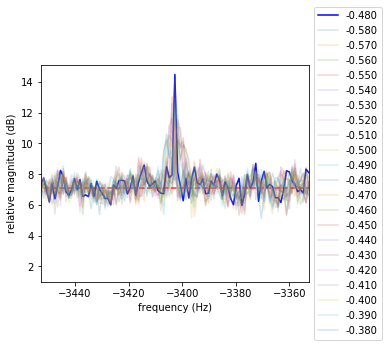

In [31]:
plt.clf()
fig,ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.plot(freqs, Hl, color='blue', label="%.3f" % best_drift)
plt.xlim(c_offset-50, c_offset+50)
for p in correlations:
    plt.plot(freqs, p[2], alpha=0.2, label="%.3f" % p[0])
plt.ylabel('relative magnitude (dB)')
plt.xlabel('frequency (Hz)')
plt.hlines(N0, min(freqs), max(freqs), color='red', alpha=0.8, linestyle='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()